In [1]:
import _nb_utils
%load_ext autoreload
%autoreload 2

In [2]:
from prompter import *
from data import *
from utils import *
from path import *
from config import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from functools import partial

import torch
import torchvision
from torchvision.models import segmentation as segmodels
from torchvision.models.mobilenetv3 import mobilenet_v3_large, MobileNet_V3_Large_Weights, MobileNetV3
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms._presets import SemanticSegmentation
import torch.nn.functional as F
from torchvision.utils import make_grid

# Model

In [4]:
print(torch.hub.get_dir())
print(CONFIG["device"])

/home/olivieri/exp/data/torch_weights
cuda


In [5]:
BY_MODEL = "LRASPP_MobileNet_V3"
SPLIT_BY = "non-splitted"

mask_prs_path = get_mask_prs_path(BY_MODEL)
mask_prs_path

PosixPath('/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/_mask_prs_')

In [ ]:
model = segmodels.lraspp_mobilenet_v3_large(weights=None, weights_backbone=None).to(CONFIG["device"])
model.load_state_dict(torch.load(TORCH_WEIGHTS_CHECKPOINTS / ("lraspp_mobilenet_v3_large-baseline_250627_1742" + ".pth")))
model.eval()

preprocess = partial(SemanticSegmentation, resize_size=CONFIG['seg']['image_size'])() # same as default transforms, but with custom resizing.

# Inference

In [7]:
idxs = range(0, 10)
img_paths_to_upload = image_val_UIDs[idxs]

sc_list = [get_sc(SCS_PATH / (img_path + ".jpg"), CONFIG['seg']['image_size'], center_crop=True) for img_path in img_paths_to_upload]
gt_list = [get_gt(GTS_PATH / (img_path + ".png"), CLASS_MAP_VOID, CONFIG['seg']['image_size'], center_crop=True) for img_path in img_paths_to_upload]

In [8]:
# pr_list = [get_pr(get_mask_prs_path(BY_MODEL) / f"mask_pr_{i}.png", CLASS_MAP, 520, center_crop=True) for i, img_path in enumerate(img_paths_to_upload)]
# apply_colormap(pr_list[4], COLOR_MAP_DICT)

In [9]:
scs = torch.stack(sc_list, dim=0)
gts = torch.stack(gt_list, dim=0)
scs.shape, gts.shape

(torch.Size([10, 3, 520, 520]), torch.Size([10, 1, 520, 520]))

In [10]:
x = preprocess(scs)
logits = model(x)["out"]
prs = logits.argmax(dim=1, keepdim=True).float()
assert scs.shape[2:] == gts.shape[2:] == prs.shape[2:]
prs.shape

torch.Size([10, 1, 520, 520])

In [11]:
gts_all_classes = (gts[:, 0] == torch.arange(NUM_CLASSES_VOID).to(CONFIG["device"])[:, None, None, None]).swapaxes(0, 1)
prs_all_classes = (prs[:, 0] == torch.arange(NUM_CLASSES).to(CONFIG["device"])[:, None, None, None]).swapaxes(0, 1)
gts_all_classes.shape, prs_all_classes.shape

(torch.Size([10, 22, 520, 520]), torch.Size([10, 21, 520, 520]))

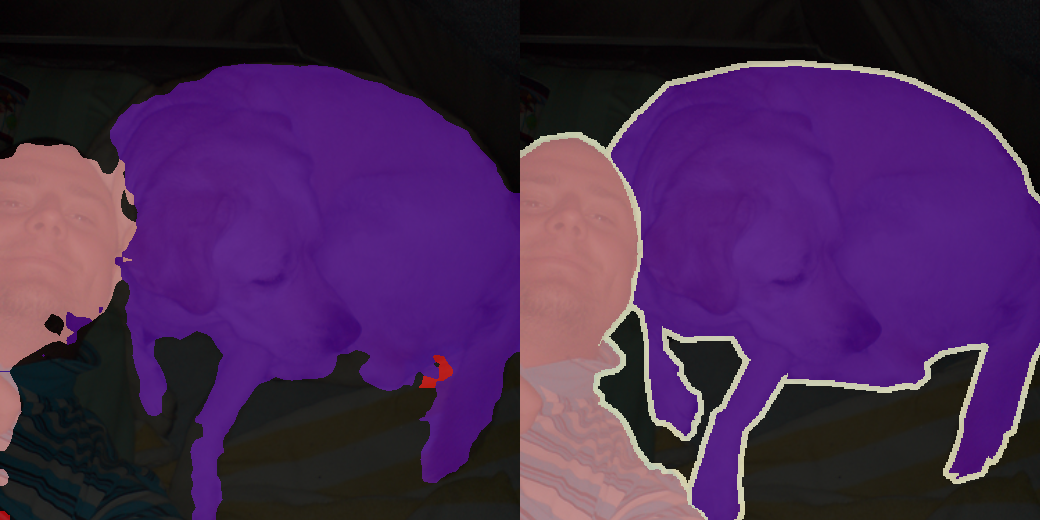

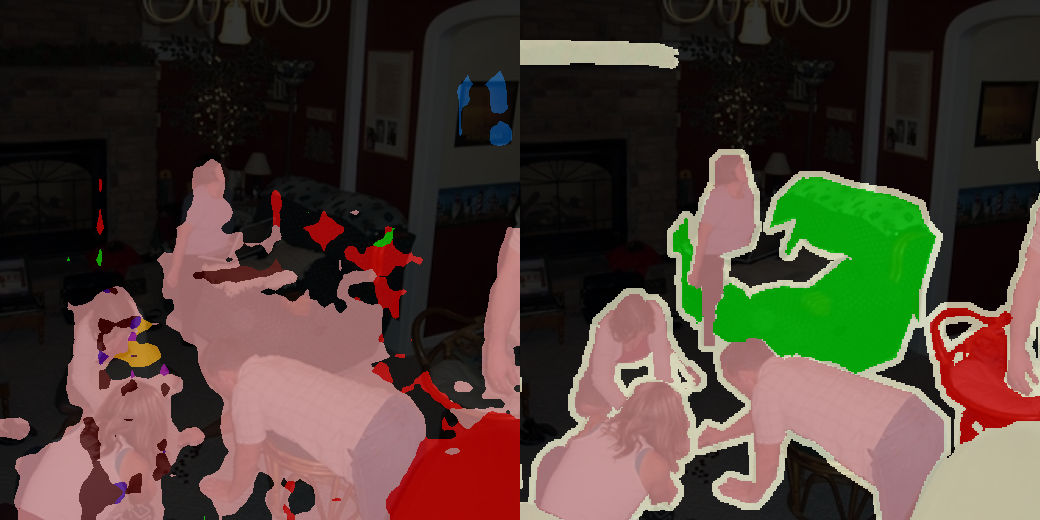

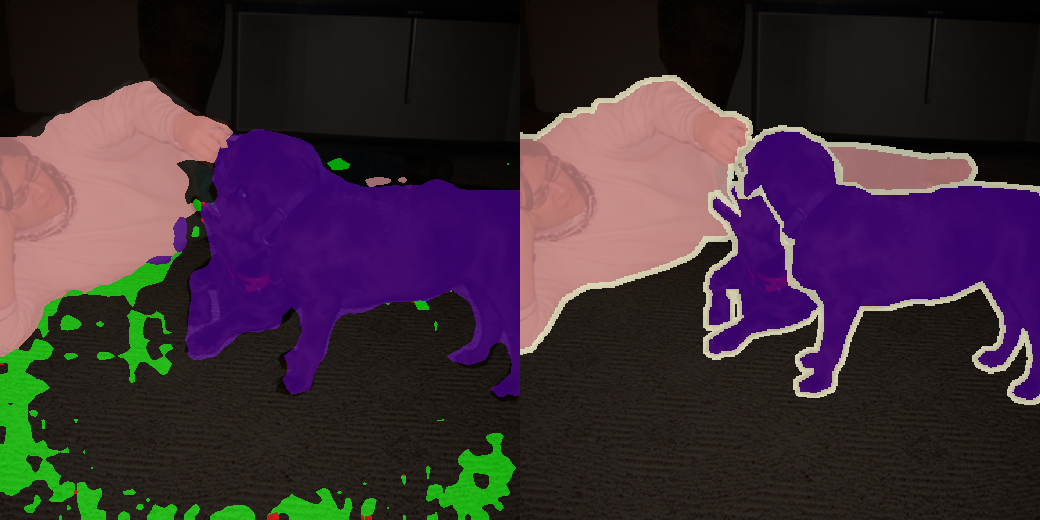

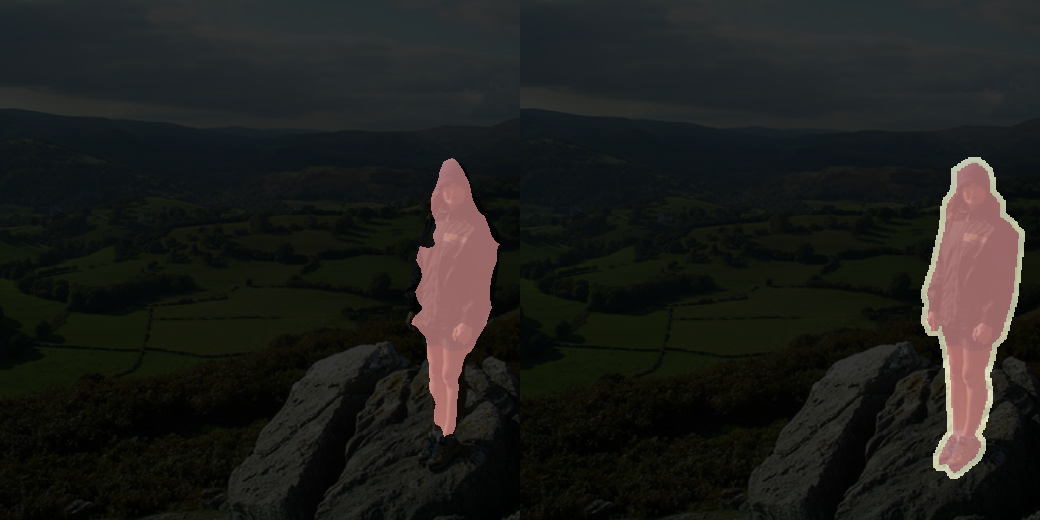

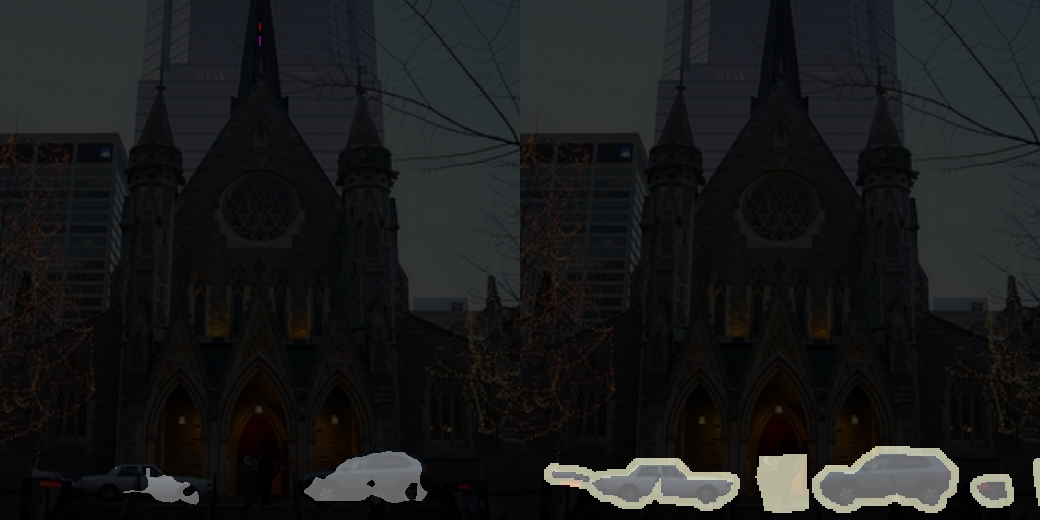

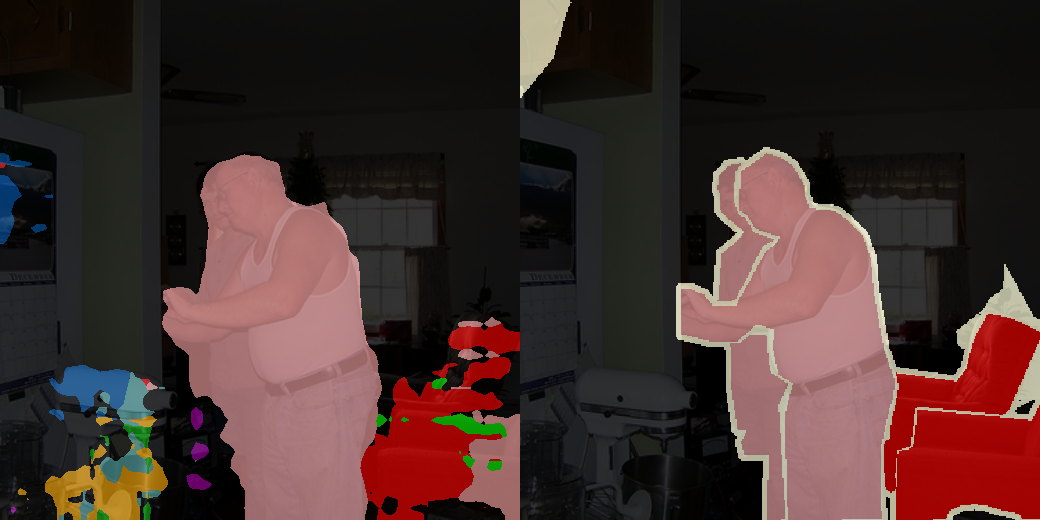

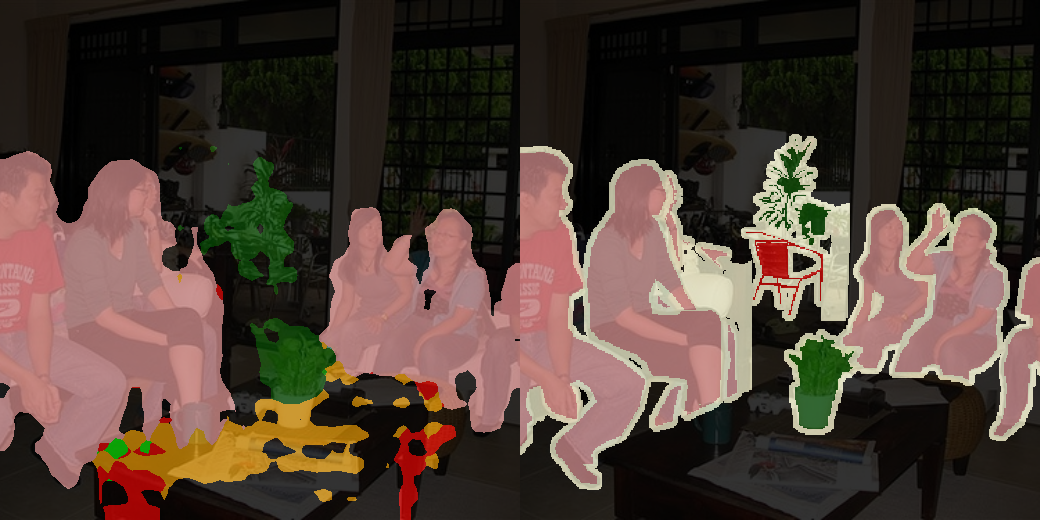

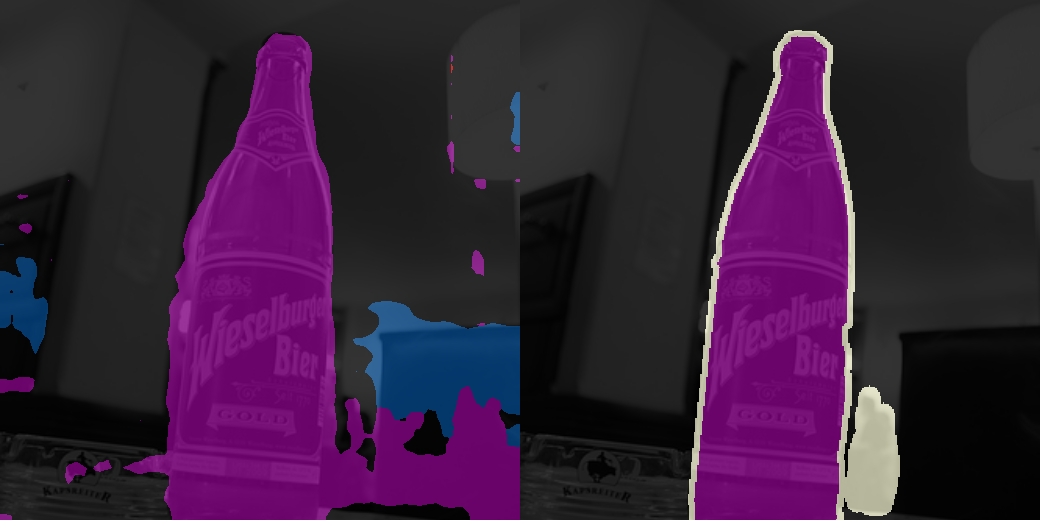

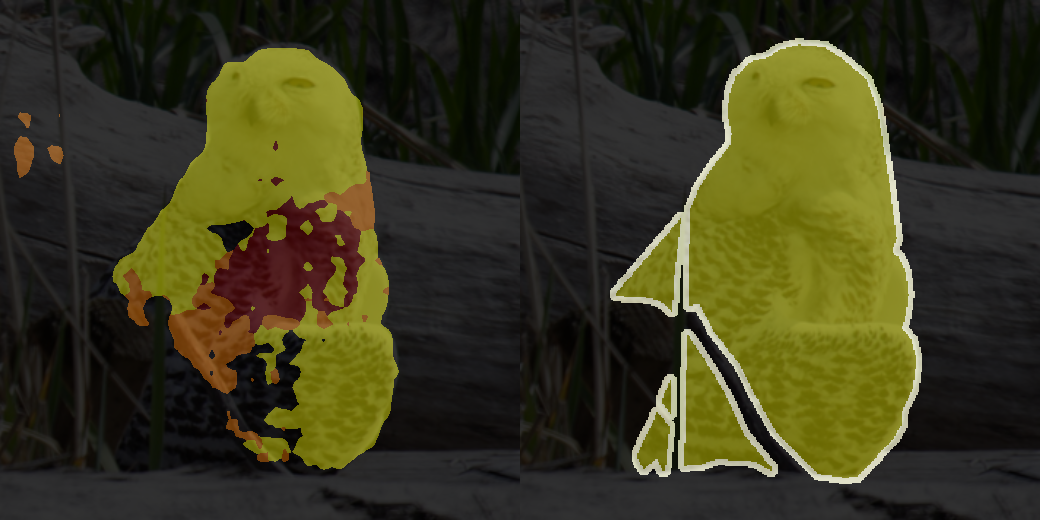

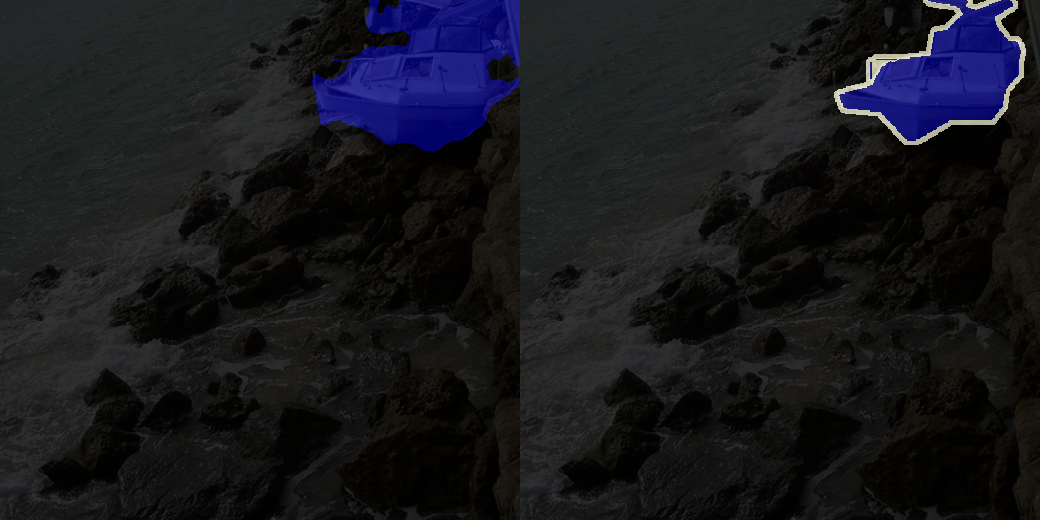

In [13]:
for i, idx in enumerate(idxs):
    # pr_ovr = draw_segmentation_masks(scs[i], prs_all_classes[i], colors=list(COLOR_MAP_DICT.values()))
    pr_col = apply_colormap(prs[i].squeeze(1), COLOR_MAP_DICT, NUM_CLASSES)
    gt_col = apply_colormap(gts[i].squeeze(1), COLOR_MAP_VOID_DICT, NUM_CLASSES_VOID)
    pr_col_img = to_pil_image(pr_col)
    gt_col_img = to_pil_image(gt_col)
    sc_img = to_pil_image(scs[i])

    pr_ovr = Image.blend(sc_img, pr_col_img, 0.8)
    gt_ovr = Image.blend(sc_img, gt_col_img, 0.8)
    
    concat_imgs = Image.new('RGB', (pr_ovr.width + gt_ovr.width, pr_ovr.height))
    concat_imgs.paste(pr_ovr, (0, 0))
    concat_imgs.paste(gt_ovr, (pr_ovr.width, 0))
    display(concat_imgs)

    # torchvision.utils.save_image(prs[i], mask_prs_path / f"mask_pr_{idx}.png", value_range=(0, 255), normalize=True)